In [ ]:
import torch
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Subset
from torchvision.models.mobilenet import mobilenet_v2, MobileNet_V2_Weights
from torch.optim.lr_scheduler import StepLR
from torch.nn import CrossEntropyLoss

from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import mlflow

SEED = 42
torch.manual_seed(SEED)
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("MNIST")

2024/03/09 17:06:14 INFO mlflow.tracking.fluent: Experiment with name 'MNIST' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/920408031089973856', creation_time=1710003974367, experiment_id='920408031089973856', last_update_time=1710003974367, lifecycle_stage='active', name='MNIST', tags={}>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Loading Data

In [ ]:
transform = v2.Compose([
    v2.RandomRotation((-7.0,7.0)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.1307,), (0.3081,)),
])

In [ ]:
VALIDATION_SIZE = 0.05
mnist = datasets.MNIST(
    'data',
    train=True,
    download=True,
    transform=transform
)
# stratified split
train_idx, val_idx = train_test_split(
    np.arange(len(mnist)),
    test_size=VALIDATION_SIZE,
    random_state=SEED,
    shuffle=True,
    stratify=mnist.targets
)

train = Subset(mnist, train_idx)
validation = Subset(mnist, val_idx)

test = datasets.MNIST(
    'data',
    train=False,
    download=True,
    transform=transform
)
len(train), len(validation), len(test)

(57000, 3000, 10000)

In [ ]:
BATCH_SIZE = 500
NUM_WORKERS = 4
train_loader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
val_loader = DataLoader(
    validation,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
test_loader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

## EDA

In [ ]:
print("Train distribution: ")
Counter(label for _, label in train)

Train distribution: 


Counter({1: 6405,
         7: 5952,
         3: 5824,
         2: 5660,
         9: 5652,
         0: 5627,
         6: 5622,
         8: 5558,
         4: 5550,
         5: 5150})

In [ ]:
tensor_img_transform = v2.ToPILImage()

9 torch.Size([1, 28, 28])


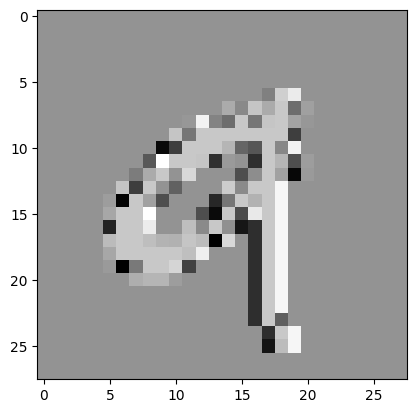

In [ ]:
idx = 1000
print(train[idx][1], train[idx][0].shape)
img = tensor_img_transform(train[idx][0].data)
plt.imshow(img, cmap="gray")
plt.show()

## Fine-tuning MobileNetV2

In [ ]:
def train(model, loss_func, optimizer, device, data_loader, epoch, log_interval=10):
    model.train()
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.repeat(1, 3, 1, 1)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data),
                len(data_loader.dataset),
                100 * batch_idx / len(data_loader),
                loss.item()
            ))
    return loss.item()

In [ ]:
def validation(model, device, data_loader, loss_func):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data = data.repeat(1, 3, 1, 1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += loss_func(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(data_loader.dataset)
    accuracy = 100 * correct / len(data_loader.dataset)

    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        val_loss,
        correct,
        len(data_loader.dataset),
        accuracy,
    ))
    return val_loss, accuracy

In [ ]:
# load pre-trained model
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)
# update the last layer to return only 10 outputs instead of 1000
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=10)
model.to(device)

In [ ]:
params = {
    "epochs": 5,
    "learning_rate": 0.2,
    "momentum": 0.8,
    "reduce_lr_gamma": 0.7,
}

LOSS_FUNCTION = CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=params["learning_rate"], momentum=params["momentum"])
# optimizer = optim.Adadelta(model.parameters(), lr=params["learning_rate"])
# scheduler = StepLR(optimizer, step_size=1, gamma=params["reduce_lr_gamma"])

with mlflow.start_run(run_name="v2_sgd"):
    mlflow.log_params({
        "batch_size": BATCH_SIZE,
        "optimizer": "SGD",
        **params
    })

    for epoch in range(1, params["epochs"] + 1):
        train_loss = train(model, LOSS_FUNCTION, optimizer, device, train_loader, epoch)
        mlflow.log_metric("train_loss", train_loss, step=epoch)

        val_loss, val_accuracy = validation(model, device, val_loader, LOSS_FUNCTION)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)

        # scheduler.step()

    mlflow.pytorch.log_model(model, "model")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Epoch: 1 [0/57000 (0%)]	Loss: 2.360313
Train Epoch: 1 [5000/57000 (9%)]	Loss: 0.956260
Train Epoch: 1 [10000/57000 (18%)]	Loss: 0.390390
Train Epoch: 1 [15000/57000 (26%)]	Loss: 0.226124
Train Epoch: 1 [20000/57000 (35%)]	Loss: 0.316142
Train Epoch: 1 [25000/57000 (44%)]	Loss: 0.164920
Train Epoch: 1 [30000/57000 (53%)]	Loss: 0.183805
Train Epoch: 1 [35000/57000 (61%)]	Loss: 0.105684
Train Epoch: 1 [40000/57000 (70%)]	Loss: 0.201002
Train Epoch: 1 [45000/57000 (79%)]	Loss: 0.128484
Train Epoch: 1 [50000/57000 (88%)]	Loss: 0.164395
Train Epoch: 1 [55000/57000 (96%)]	Loss: 0.081294
Validation set: Average loss: 0.0003, Accuracy: 2863/3000 (95%)
Train Epoch: 2 [0/57000 (0%)]	Loss: 0.081058
Train Epoch: 2 [5000/57000 (9%)]	Loss: 0.060998
Train Epoch: 2 [10000/57000 (18%)]	Loss: 0.144577
Train Epoch: 2 [15000/57000 (26%)]	Loss: 0.104682
Train Epoch: 2 [20000/57000 (35%)]	Loss: 0.055112
Train Epoch: 2 [25000/57000 (44%)]	Loss: 0.118724
Train Epoch: 2 [30000/57000 (53%)]	Loss: 0.103179


2024/03/09 17:30:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.1.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Validation set: Average loss: 0.0001, Accuracy: 2949/3000 (98%)


2024/03/09 17:30:24 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.23+cuda12.cudnn89) contains a local version label (+cuda12.cudnn89). MLflow logged a pip requirement for this package as 'jaxlib==0.4.23' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/03/09 17:30:24 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.16.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.16.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


## Test set metrics

In [ ]:
test_loss, test_accuracy = validation(model, device, test_loader, LOSS_FUNCTION)
print(test_loss, test_accuracy)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation set: Average loss: 0.0001, Accuracy: 9842/10000 (98%)
0.00010450141448527574 98.42


In [ ]:
torch.save(model, "../data/models/mnist_model.pth")